# RE Forecasting: Model Fitting

Some thoughts:

1. I am using XGBoost with decision trees. This has some important implications:
    - XGBoost can handle missing values (has some smart imputation strategies) 
    - XGBoost with decision trees is not sensitive to data scaling
    
    Both aspects have to be reconsidered if switching to a different modelling approach!

2. Some of the weather features are highly correlated. However, my problem is rather too little information (due to the averaging across clusters) than too much and since the weather data per location should be precise, I am not too worried about excessive noise. Therefore, I will not run PCA on the features at this point and instead, I will use all features available (and only exclude features based on their importance in the model).

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt, timedelta

# modelling
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from REForecasting import *

In [100]:
fpath = "C:/Users/piasw/Desktop/WBS/final project/final_data"

## Solar

##### Load data

In [101]:
solar_df = pd.read_parquet(f"{fpath}/solar_data_final_100_clusters_20180601-20230531.parquet")

##### Make sure there are no nan values in generation data (this should be moved to preprocessing at some point!)

In [102]:
solar_df.isna().sum()[solar_df.isna().sum()>0]

direct_normal_irradiance    2
generated_electricity       5
dtype: int64

In [103]:
# Simple forward fill, might need better methods if there are a lot of missing values
solar_df["generated_electricity"] = solar_df["generated_electricity"].fillna(method="ffill")

##### Add datetime features

In [104]:
solar_df = add_datetime_features(solar_df)

##### Create train/test split

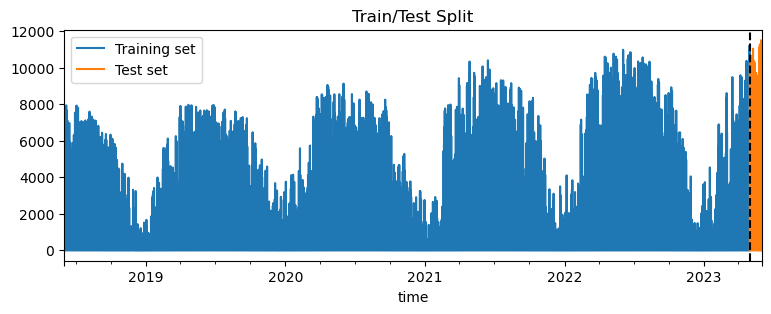

In [105]:
# split_date = "2022-06-01"
split_date = "2023-05-01"
solar_train, solar_test = train_test_split(solar_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:2687.27041	validation_1-rmse:4723.11944
[500]	validation_0-rmse:287.28794	validation_1-rmse:534.12974
[1000]	validation_0-rmse:249.53715	validation_1-rmse:509.30525
[1500]	validation_0-rmse:231.81778	validation_1-rmse:502.87061
[1608]	validation_0-rmse:228.67768	validation_1-rmse:502.47201
RSME = 502.33
MAPE = 20937857861159684.00


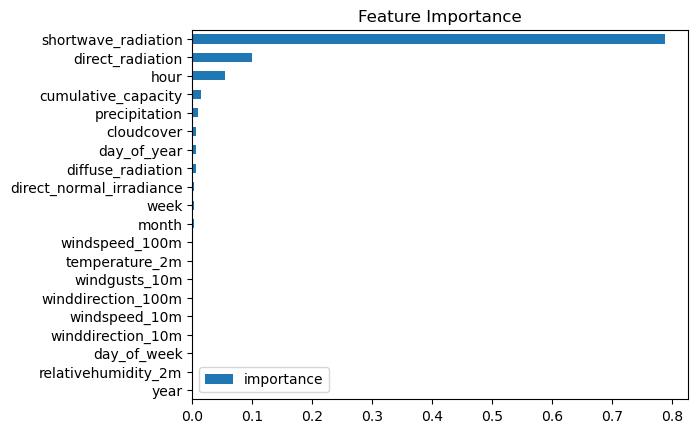

In [109]:
base_xgb, solar_fi = run_baseline_xgboost(solar_train, solar_test, learning_rate=0.01)

In [8]:
solar_fi.sort_values(by="importance", ascending=False).index

NameError: name 'solar_fi' is not defined

In [8]:
solar_features = ['shortwave_radiation', 'direct_radiation', 'hour',
                  'cumulative_capacity', 'precipitation', 'cloudcover',
                  'diffuse_radiation', 'month', 'direct_normal_irradiance']

##### Step 2: Grid search with cross-validation

In [9]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.01],
    # "max_depth": [6, 8, 10],
}
solar_xgb =  run_cv_xgboost(solar_train, solar_features, params)

Running cross validation...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3; 1/3] START learning_rate=0.01, max_depth=6, n_estimators=2000..........
[0]	validation_0-rmse:2530.68569	validation_1-rmse:4114.34873
[500]	validation_0-rmse:306.70783	validation_1-rmse:564.45110
[881]	validation_0-rmse:282.82097	validation_1-rmse:543.61089
[CV 1/3; 1/3] END learning_rate=0.01, max_depth=6, n_estimators=2000;, score=-356.195 total time=  41.5s
[CV 2/3; 1/3] START learning_rate=0.01, max_depth=6, n_estimators=2000..........
[0]	validation_0-rmse:2530.57702	validation_1-rmse:4114.22919
[500]	validation_0-rmse:305.49706	validation_1-rmse:580.67706
[507]	validation_0-rmse:304.72063	validation_1-rmse:579.70389
[CV 2/3; 1/3] END learning_rate=0.01, max_depth=6, n_estimators=2000;, score=-203.648 total time=  27.9s
[CV 3/3; 1/3] START learning_rate=0.01, max_depth=6, n_estimators=2000..........
[0]	validation_0-rmse:2530.57872	validation_1-rmse:4114.21407
[500]	validation_0-rmse:30

##### Predict held-out test data

In [121]:
solar_xgb = base_xgb

In [122]:
solar_test, rmse, mape = predict_test(solar_test, solar_xgb)

RSME = 502.33
MAPE = 20937857861159684.00


In [11]:
solar_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

##### Plot predictions and actual generation

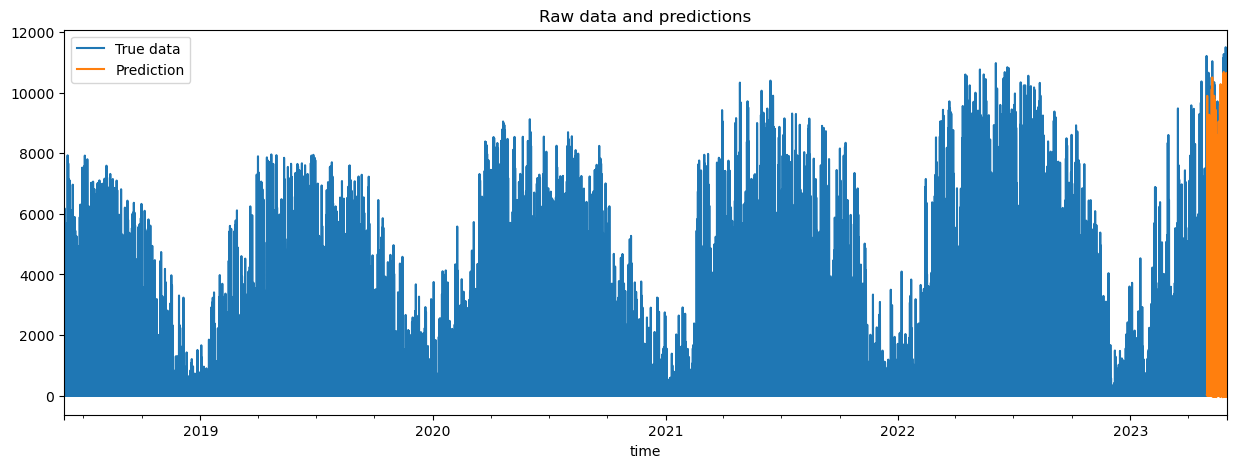

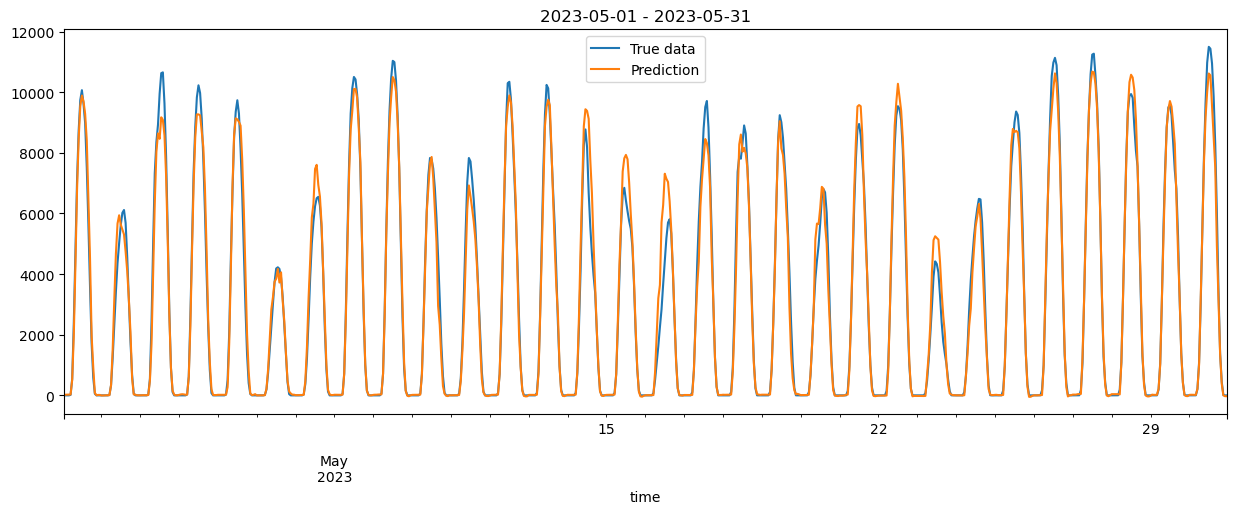

In [123]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(solar_df, solar_test, plot_start, plot_end)

##### Save model

In [124]:
# save
mname = "solar_xgboost_cv_5years_100clusters"
solar_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# solar_xgb = xgb.XGBRegressor()
# solar_xgb.load_model(f"{fpath}/models/{mname}.json")


## Wind - onshore

##### Load data

In [3]:
onshore_df = pd.read_parquet(f"{fpath}/wind_onshore_data_final_100_clusters_20180601-20230531.parquet")

##### Make sure there are no nan values in generation data (this should be moved to preprocessing at some point!)

In [4]:
onshore_df.isna().sum()[onshore_df.isna().sum()>0]

direct_normal_irradiance    1
generated_electricity       5
dtype: int64

In [5]:
# Simple forward fill, might need better methods if there are a lot of missing values
onshore_df["generated_electricity"] = onshore_df["generated_electricity"].fillna(method="ffill")

##### Add datetime features

In [6]:
onshore_df = add_datetime_features(onshore_df)

##### Create train/test split

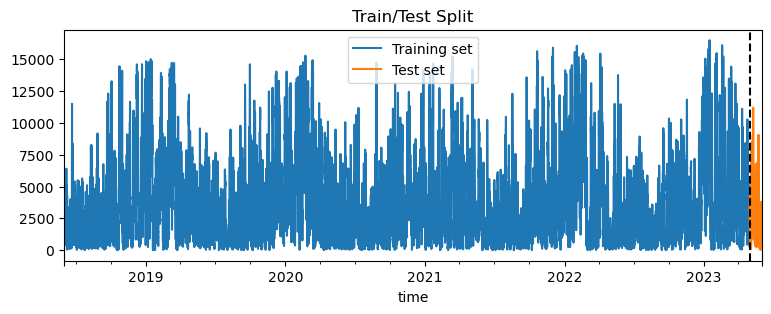

In [7]:
split_date = "2023-05-01"
onshore_train, onshore_test = train_test_split(onshore_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:5150.74072	validation_1-rmse:3776.47977
[500]	validation_0-rmse:600.80527	validation_1-rmse:660.40996
[839]	validation_0-rmse:562.40698	validation_1-rmse:638.93311
RSME = 638.28


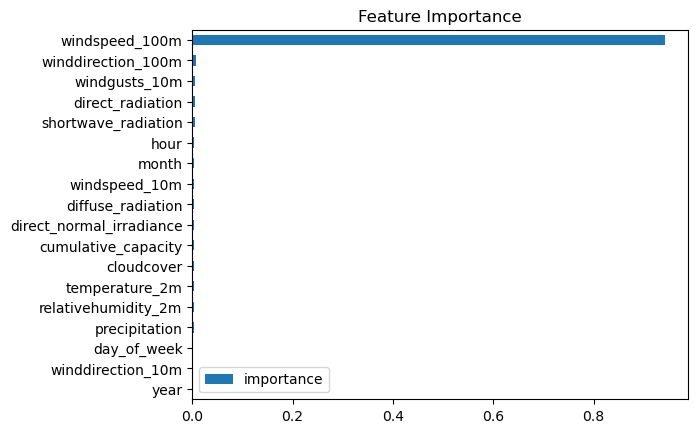

In [34]:
base_xgb, onshore_fi = run_baseline_xgboost(onshore_train, onshore_test)

In [35]:
onshore_fi.sort_values(by="importance", ascending=False).index

Index(['windspeed_100m', 'winddirection_100m', 'windgusts_10m',
       'direct_radiation', 'shortwave_radiation', 'hour', 'month',
       'windspeed_10m', 'diffuse_radiation', 'direct_normal_irradiance',
       'cumulative_capacity', 'cloudcover', 'temperature_2m',
       'relativehumidity_2m', 'precipitation', 'day_of_week',
       'winddirection_10m', 'year'],
      dtype='object')

In [8]:
# keep some reasonable features despite apparently negligible feature importance 
onshore_features = ['windspeed_100m', 'winddirection_100m', 'hour', 'month', 'cumulative_capacity']

##### Step 2: Grid search with cross-validation

In [9]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.01, 0.005],
    "max_depth": [4, 6, 8],
}
onshore_xgb =  run_cv_xgboost(onshore_train, onshore_features, params)

Running cross validation...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START learning_rate=0.01, max_depth=4, n_estimators=2000..........
[0]	validation_0-rmse:5033.20984	validation_1-rmse:6583.54066
[500]	validation_0-rmse:747.32204	validation_1-rmse:1072.18742
[835]	validation_0-rmse:734.57014	validation_1-rmse:1048.71593
[CV 1/3; 1/6] END learning_rate=0.01, max_depth=4, n_estimators=2000;, score=-1351.584 total time=  16.2s
[CV 2/3; 1/6] START learning_rate=0.01, max_depth=4, n_estimators=2000..........
[0]	validation_0-rmse:5032.71043	validation_1-rmse:6582.97203
[487]	validation_0-rmse:709.48089	validation_1-rmse:1005.99392
[CV 2/3; 1/6] END learning_rate=0.01, max_depth=4, n_estimators=2000;, score=-683.238 total time=  11.3s
[CV 3/3; 1/6] START learning_rate=0.01, max_depth=4, n_estimators=2000..........
[0]	validation_0-rmse:5032.76557	validation_1-rmse:6583.02996
[500]	validation_0-rmse:697.39918	validation_1-rmse:1109.66913
[692]	validation_0-r

##### Predict held-out test data

In [10]:
onshore_test, rmse = predict_test(onshore_test, onshore_xgb)

RSME = 697.46


##### Plot predictions and actual generation

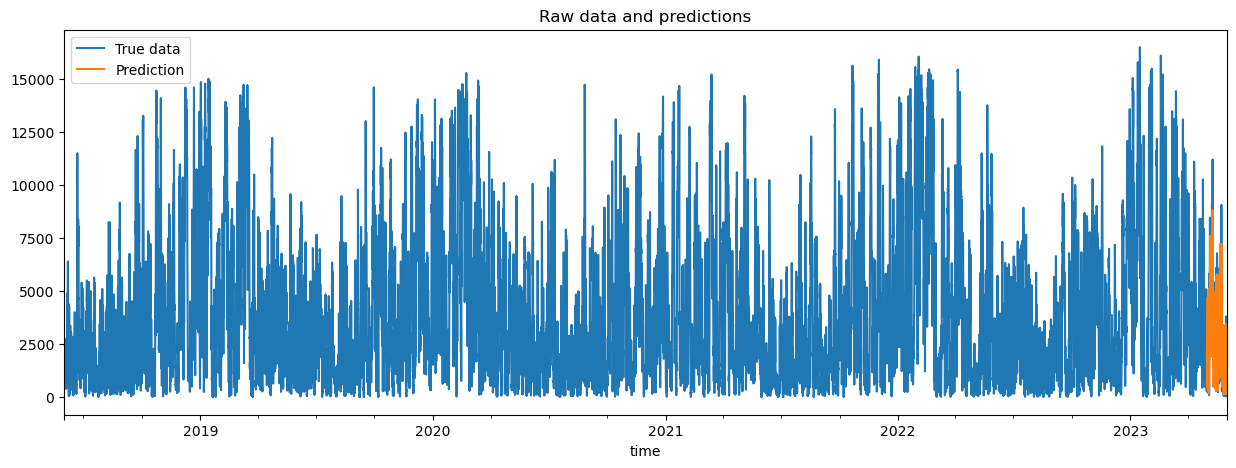

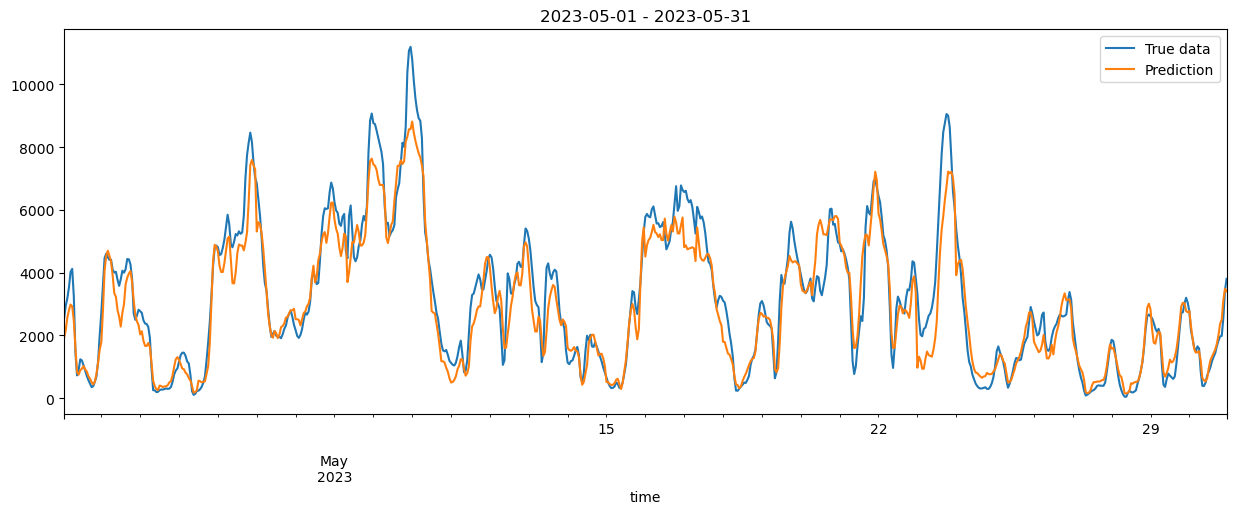

In [13]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(onshore_df, onshore_test, plot_start, plot_end)

##### Save model

In [15]:
# save
mname = "onshore_xgboost_cv_5years_100clusters"
onshore_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# onshore_xgb = xgb.XGBRegressor()
# onshore_xgb.load_model(f"{mpath}/models/{mname}.json")


## Wind offshore

##### Load data

In [3]:
offshore_df = pd.read_parquet(f"{fpath}/wind_offshore_data_final_6_clusters_20180601-20230531.parquet")

##### Add datetime features

In [4]:
offshore_df = add_datetime_features(offshore_df)

##### Create train/test split

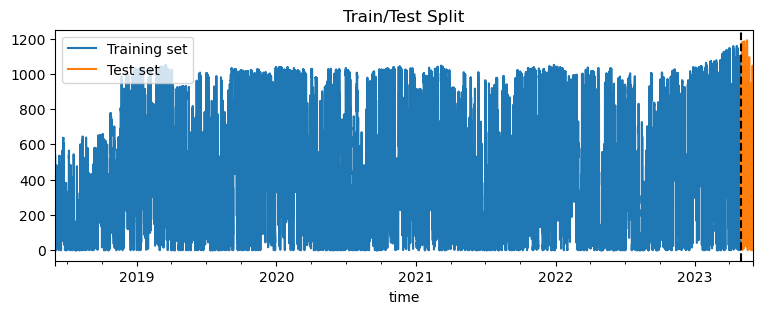

In [5]:
split_date = "2023-05-01"
offshore_train, offshore_test = train_test_split(offshore_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:549.75743	validation_1-rmse:582.83532
[500]	validation_0-rmse:107.45745	validation_1-rmse:177.23496
[534]	validation_0-rmse:106.60115	validation_1-rmse:177.18668
RSME = 177.11


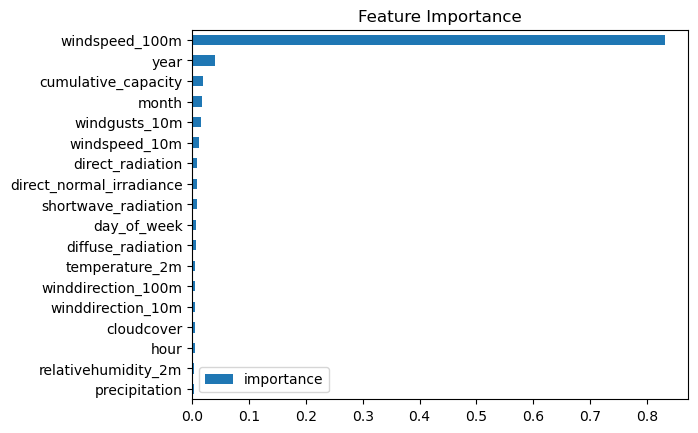

In [25]:
base_xgb, offshore_fi = run_baseline_xgboost(offshore_train, offshore_test)

In [26]:
offshore_fi.sort_values(by="importance", ascending=False).index

Index(['windspeed_100m', 'year', 'cumulative_capacity', 'month',
       'windgusts_10m', 'windspeed_10m', 'direct_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'day_of_week',
       'diffuse_radiation', 'temperature_2m', 'winddirection_100m',
       'winddirection_10m', 'cloudcover', 'hour', 'relativehumidity_2m',
       'precipitation'],
      dtype='object')

In [10]:
# keep some reasonable features despite apparently negligible feature importance 
offshore_features = ['windspeed_100m', 'winddirection_100m', 'winddirection_10m', 'year', 
                     'cumulative_capacity', 'month', 'windgusts_10m', 'windspeed_10m', 'hour']

##### Step 2: Grid search with cross-validation

In [11]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005],
    "max_depth": [6],
}
offshore_xgb =  run_cv_xgboost(offshore_train, offshore_features, params)

Running cross validation...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:551.68678	validation_1-rmse:592.56626
[500]	validation_0-rmse:125.65334	validation_1-rmse:205.71059
[1000]	validation_0-rmse:111.82193	validation_1-rmse:195.62045
[1500]	validation_0-rmse:109.02009	validation_1-rmse:194.42373
[1701]	validation_0-rmse:108.36190	validation_1-rmse:194.29679
[CV 1/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-177.255 total time= 1.6min
[CV 2/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:551.68346	validation_1-rmse:592.56136
[500]	validation_0-rmse:125.47084	validation_1-rmse:206.17695
[1000]	validation_0-rmse:111.46363	validation_1-rmse:192.75187
[1107]	validation_0-rmse:110.72808	validation_1-rmse:192.39412
[CV 2/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-173.519

##### Predict held-out test data

In [12]:
offshore_test, rmse, mape = predict_test(offshore_test, offshore_xgb)

RSME = 183.25
MAPE = 2351935212599407.00


##### Plot predictions and actual generation

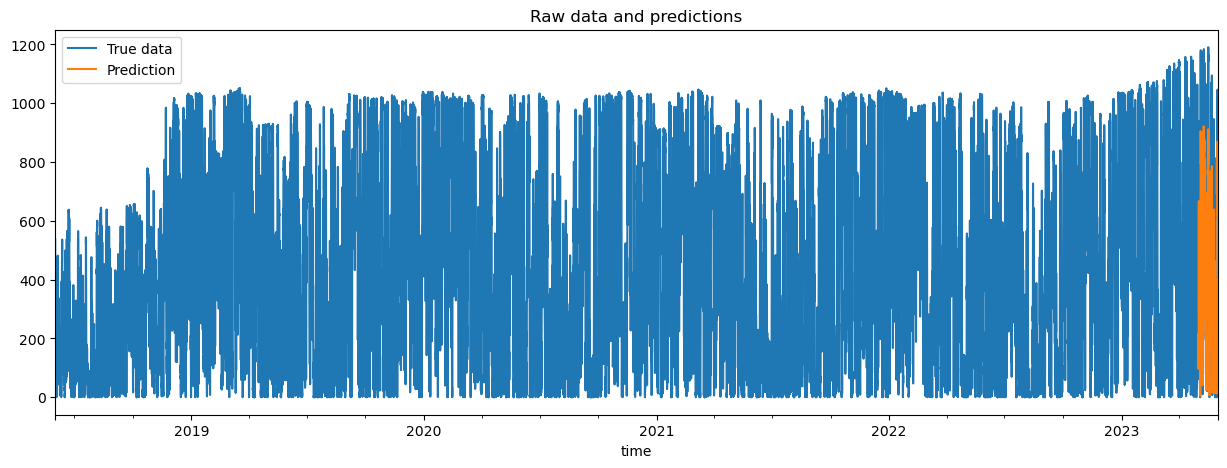

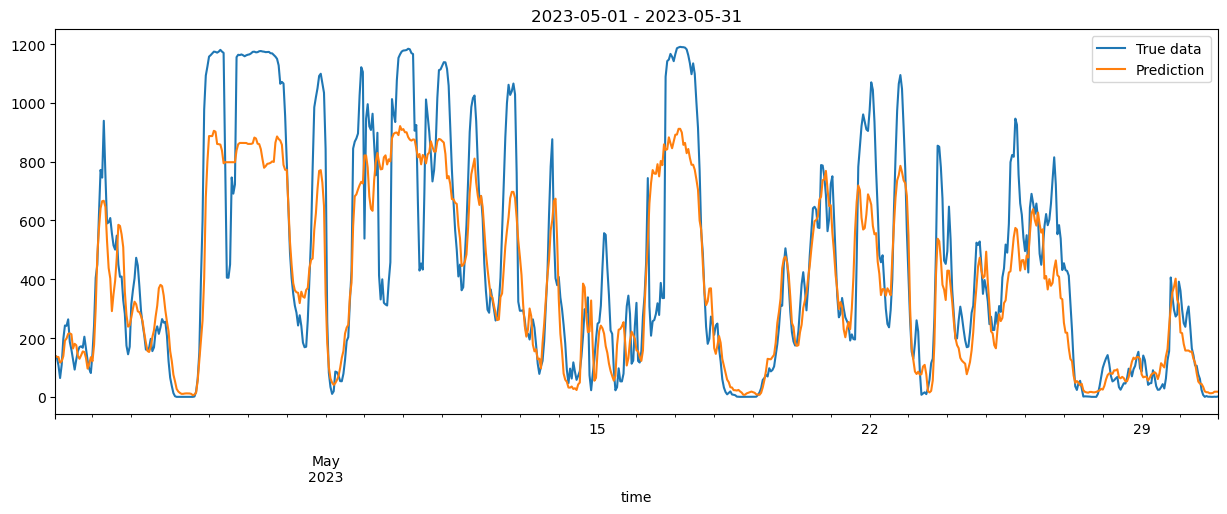

In [13]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(offshore_df, offshore_test, plot_start, plot_end)

##### Save model

In [14]:
# save
mname = "offshore_xgboost_cv_5years_100clusters"
offshore_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# offshore_xgb = xgb.XGBRegressor()
# offshore_xgb.load_model(f"{mpath}/models/{mname}.json")


## Consumption

##### Load data

In [37]:
consumption_df = pd.read_parquet(f"{fpath}/consumption_data_final_20180601-20230531.parquet")

##### Add datetime features

In [38]:
consumption_df = add_datetime_features(consumption_df)

##### Create train/test split

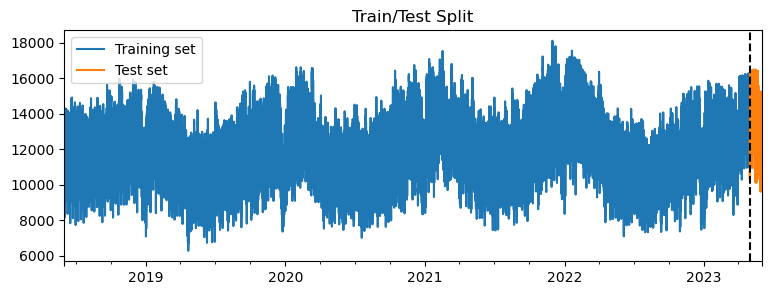

In [40]:
split_date = "2023-05-01"
consumption_train, consumption_test = train_test_split(consumption_df, split_date, target="total_consumption")

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:11972.57818	validation_1-rmse:13249.63822
[500]	validation_0-rmse:616.09444	validation_1-rmse:1074.20829
[966]	validation_0-rmse:523.97926	validation_1-rmse:1007.81992
RSME = 1004.46
MAPE = 0.06


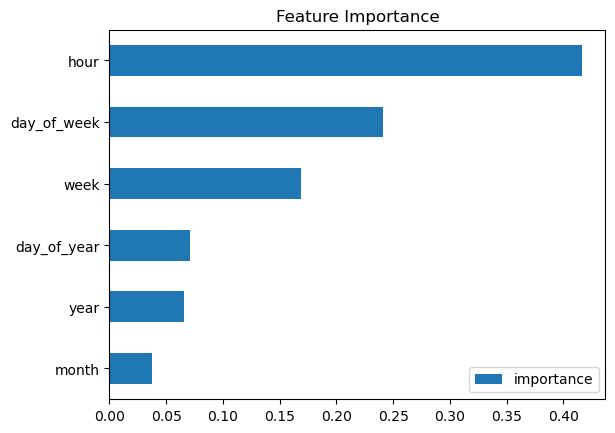

In [41]:
base_xgb, consumption_fi = run_baseline_xgboost(consumption_train, consumption_test, target="total_consumption")

In [42]:
consumption_fi.sort_values(by="importance", ascending=False).index

Index(['hour', 'day_of_week', 'week', 'day_of_year', 'year', 'month'], dtype='object')

In [43]:
consumption_features = ['hour', 'day_of_week', 'week', 'day_of_year', 'year', 'month']

Text(0.5, 1.0, 'Total electricity consumption by time of day')

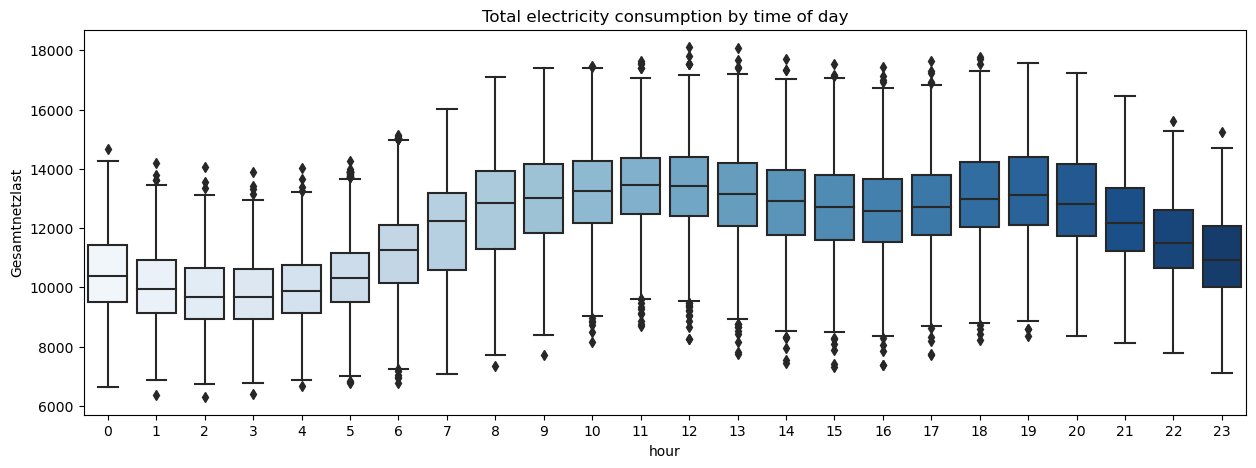

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=consumption_df, x="hour", y="total_consumption", palette="Blues")
ax.set_title("Total electricity consumption by time of day")

Text(0.5, 1.0, 'Total electricity consumption by day_of_week')

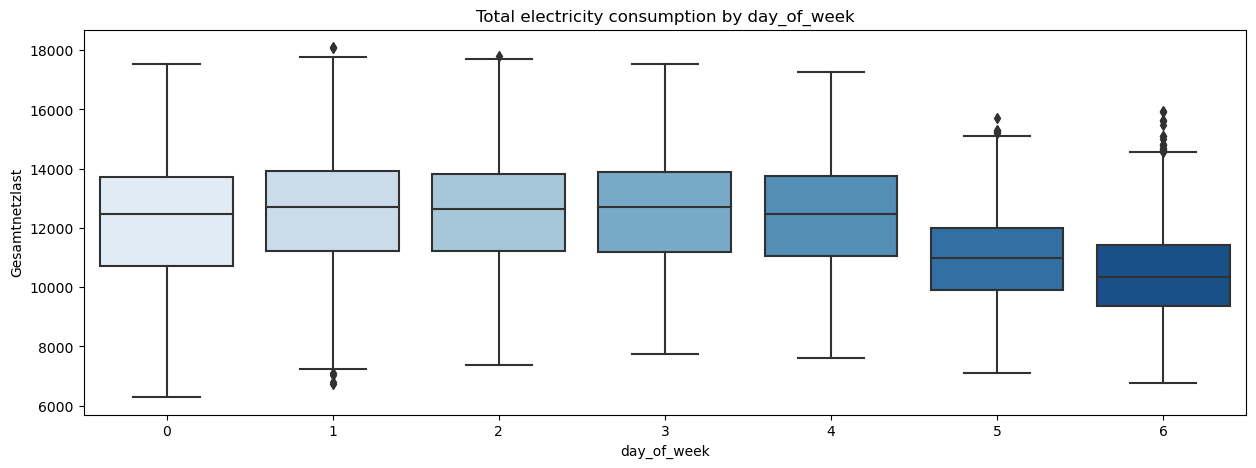

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=consumption_df, x="day_of_week", y="total_consumption", palette="Blues")
ax.set_title("Total electricity consumption by day_of_week")

Text(0.5, 1.0, 'Total electricity consumption by month')

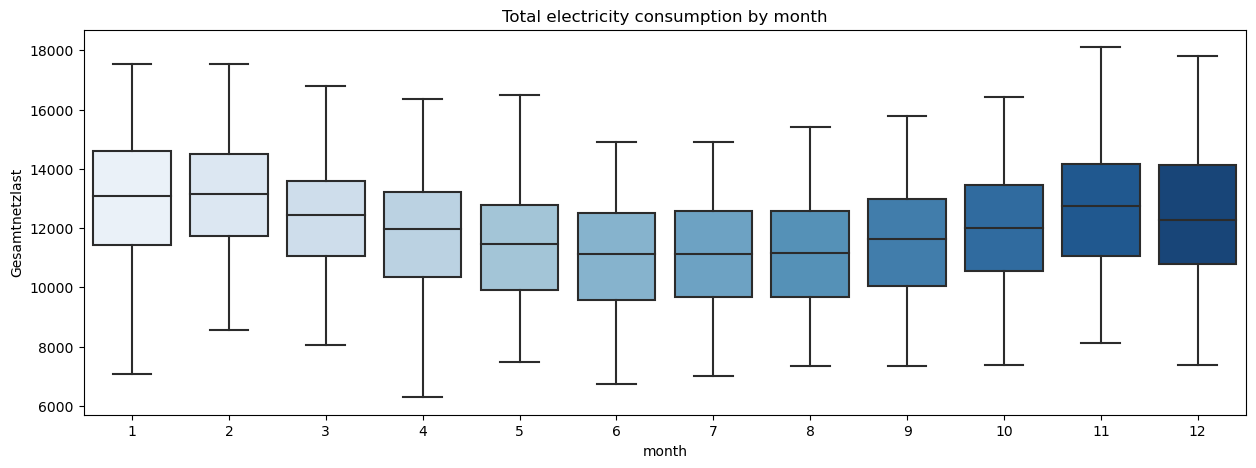

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=consumption_df, x="month", y="total_consumption", palette="Blues")
ax.set_title("Total electricity consumption by month")

Text(0.5, 1.0, 'Total electricity consumption by year')

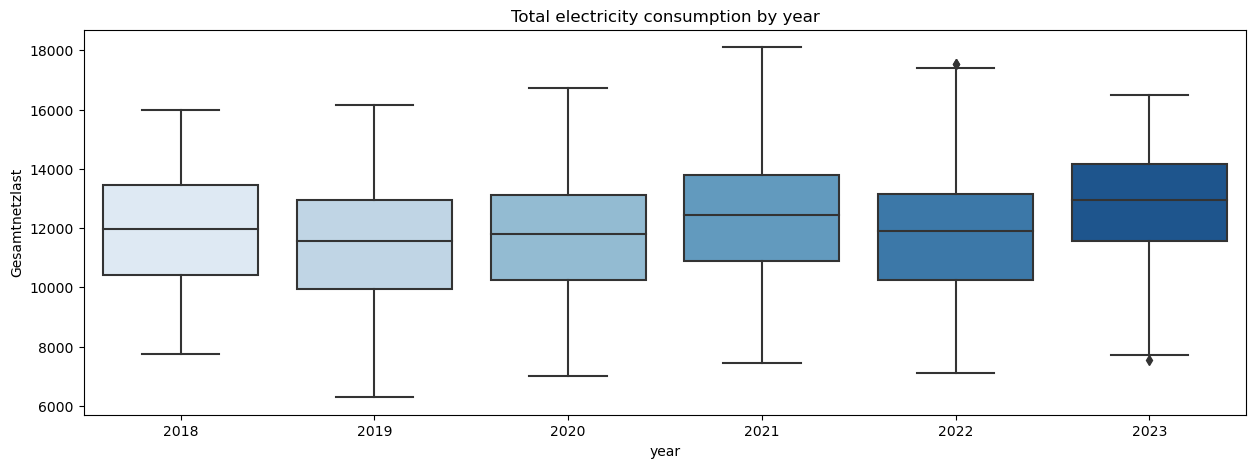

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=consumption_df, x="year", y="total_consumption", palette="Blues")
ax.set_title("Total electricity consumption by year")

Text(0.5, 1.0, 'Total electricity consumption by week')

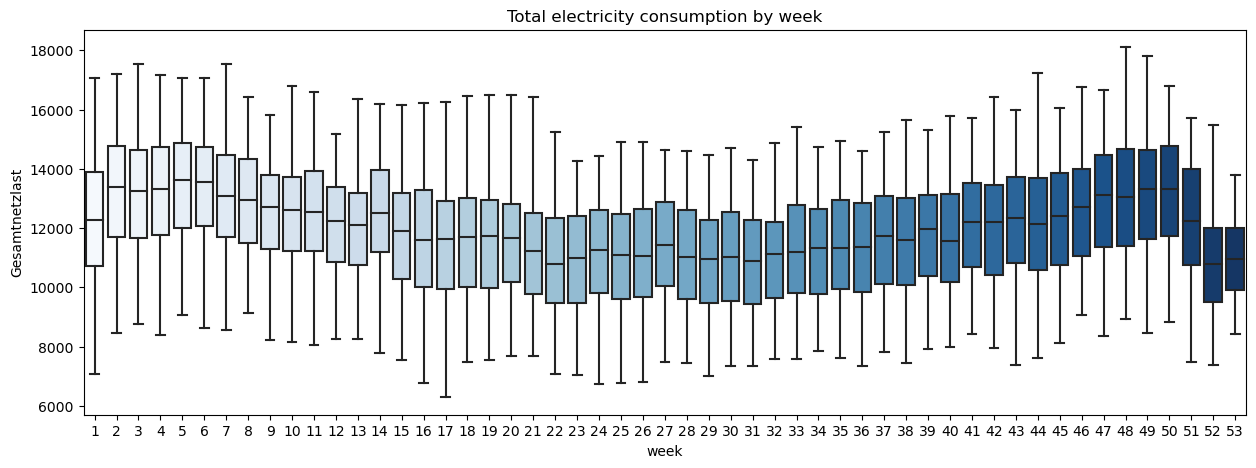

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=consumption_df, x="week", y="total_consumption", palette="Blues")
ax.set_title("Total electricity consumption by week")

Text(0.5, 1.0, 'Total electricity consumption by day of year')

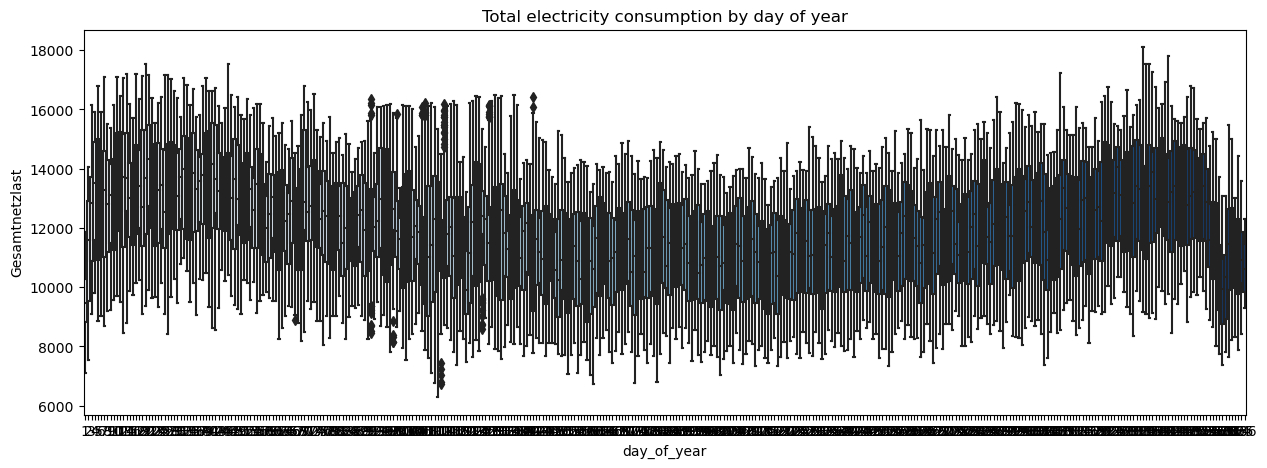

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=consumption_df, x="day_of_year", y="total_consumption", palette="Blues")
ax.set_title("Total electricity consumption by day of year")

##### Step 2: Grid search with cross-validation

In [13]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005, 0.01],
    "max_depth": [4, 6],
}
consumption_xgb = run_cv_xgboost(consumption_train, consumption_features, params, target="total_consumption")

Running cross validation...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.005, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:12001.60700	validation_1-rmse:13739.34656
[500]	validation_0-rmse:1356.55400	validation_1-rmse:3266.06672
[1000]	validation_0-rmse:870.31685	validation_1-rmse:2203.61430
[1500]	validation_0-rmse:847.78131	validation_1-rmse:2030.97551
[1999]	validation_0-rmse:838.81262	validation_1-rmse:1999.82376
[CV 1/3; 1/4] END learning_rate=0.005, max_depth=4, n_estimators=2000;, score=-1558.480 total time=  20.6s
[CV 2/3; 1/4] START learning_rate=0.005, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:12001.68531	validation_1-rmse:13739.34677
[500]	validation_0-rmse:1370.67753	validation_1-rmse:3314.49432
[1000]	validation_0-rmse:853.34835	validation_1-rmse:2416.35498
[1500]	validation_0-rmse:817.00238	validation_1-rmse:2310.23092
[1615]	validation_0-rmse:812.91141	validation_1-rmse:2304.80318
[CV

##### Predict held-out test data

In [44]:
consumption_xgb = base_xgb

In [45]:
consumption_test, rmse, mape = predict_test(consumption_test, consumption_xgb, target="total_consumption")

RSME = 1004.46
MAPE = 0.06


##### Plot predictions and actual generation

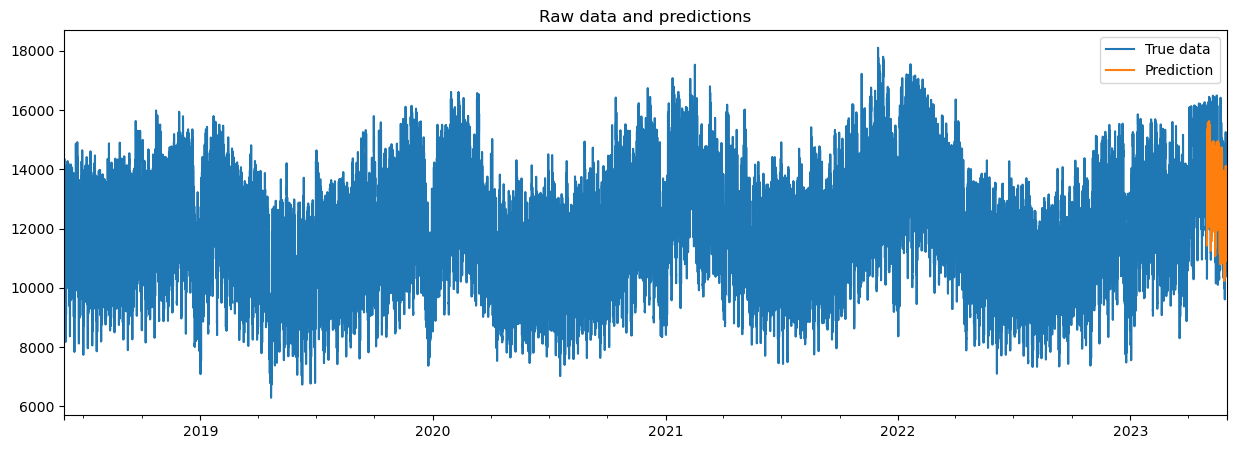

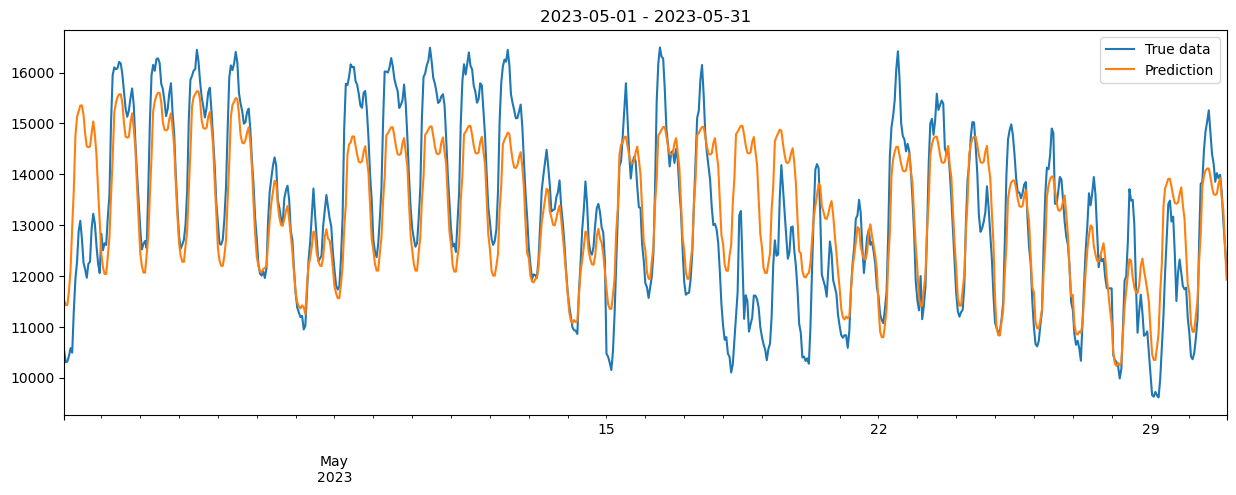

In [46]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(consumption_df, consumption_test, plot_start, plot_end, target="total_consumption")

##### Save model

In [47]:
# save
mname = "consumption_xgboost_cv_5years_100clusters"
consumption_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# consumption_xgb = xgb.XGBRegressor()
# consumption_xgb.load_model(f"{mpath}/models/{mname}.json")


## Brown Coal

##### Load data

In [73]:
brown_coal_df = pd.read_parquet(f"{fpath}/brown_coal_data_final_20180601-20230531.parquet")

##### Add datetime features

In [74]:
brown_coal_df = add_datetime_features(brown_coal_df)

##### Create train/test split

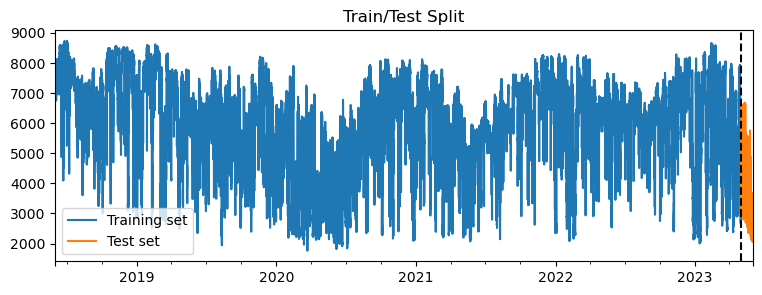

In [76]:
split_date = "2023-05-01"
# split_date = "2022-06-01"
brown_coal_train, brown_coal_test = train_test_split(brown_coal_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:6162.57938	validation_1-rmse:4217.41377
[285]	validation_0-rmse:1723.08156	validation_1-rmse:1185.13601
RSME = 1130.87
MAPE = 0.26


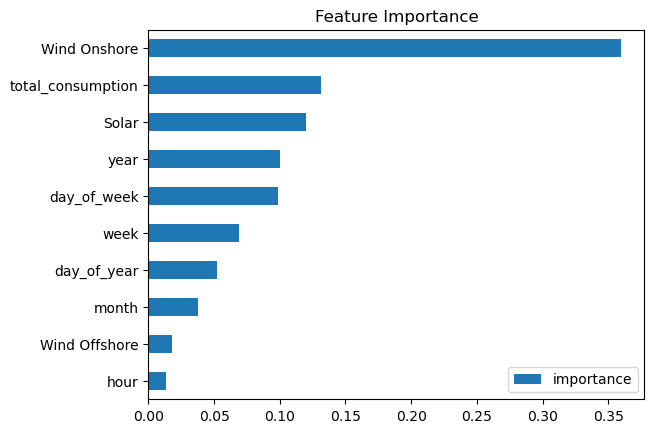

In [77]:
base_xgb, brown_coal_fi = run_baseline_xgboost(brown_coal_train, brown_coal_test, learning_rate=0.005)

In [17]:
brown_coal_fi.sort_values(by="importance", ascending=False).index

Index(['Wind Onshore', 'total_consumption', 'day_of_week', 'Solar', 'year',
       'month', 'Wind Offshore', 'hour'],
      dtype='object')

In [18]:
# keep some reasonable features despite apparently negligible feature importance 
brown_coal_features = ['Wind Onshore', 'total_consumption', 'day_of_week', 'Solar', 'year',
                       'month', 'Wind Offshore', 'hour']

##### Step 2: Grid search with cross-validation

In [32]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.001, 0.005],
    "max_depth": [4,6],
}
brown_coal_xgb =  run_cv_xgboost(brown_coal_train, brown_coal_features, params)

Running cross validation...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.001, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:6190.04177	validation_1-rmse:6254.88796
[500]	validation_0-rmse:3883.33482	validation_1-rmse:4156.57495
[1000]	validation_0-rmse:2525.32686	validation_1-rmse:2953.44367
[1500]	validation_0-rmse:1745.49858	validation_1-rmse:2241.44067
[1999]	validation_0-rmse:1313.94893	validation_1-rmse:1876.07470
[CV 1/3; 1/4] END learning_rate=0.001, max_depth=4, n_estimators=2000;, score=-1315.542 total time=  37.4s
[CV 2/3; 1/4] START learning_rate=0.001, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:6190.04468	validation_1-rmse:6254.87410
[500]	validation_0-rmse:3883.84375	validation_1-rmse:4144.31186
[1000]	validation_0-rmse:2525.87502	validation_1-rmse:2941.12176
[1500]	validation_0-rmse:1748.40639	validation_1-rmse:2254.87648
[1999]	validation_0-rmse:1316.37321	validation_1-rmse:1880.85455
[

##### Predict held-out test data

In [33]:
brown_coal_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [78]:
brown_coal_xgb = base_xgb

In [79]:
brown_coal_test, rmse, mape = predict_test(brown_coal_test, brown_coal_xgb)

RSME = 1130.87
MAPE = 0.26


##### Plot predictions and actual generation

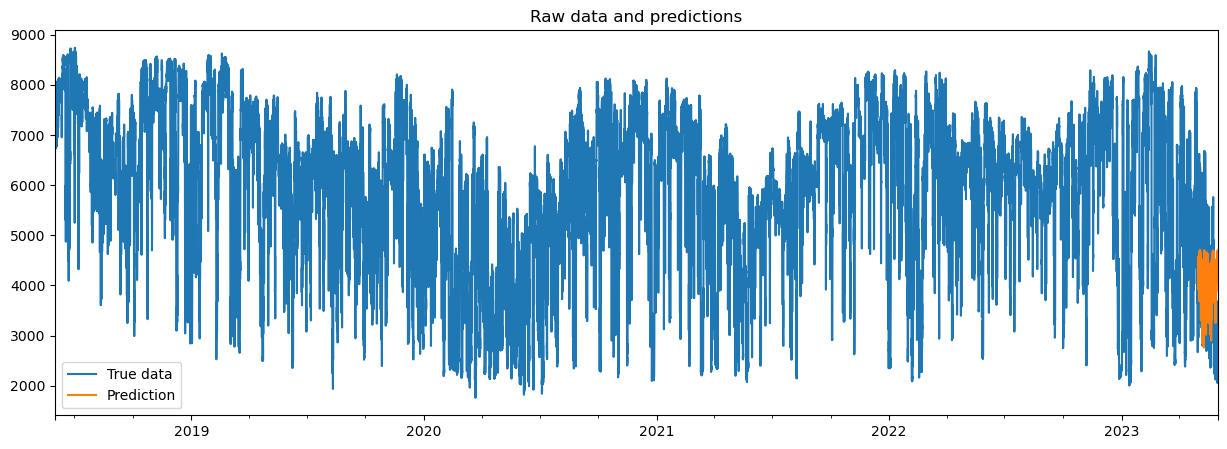

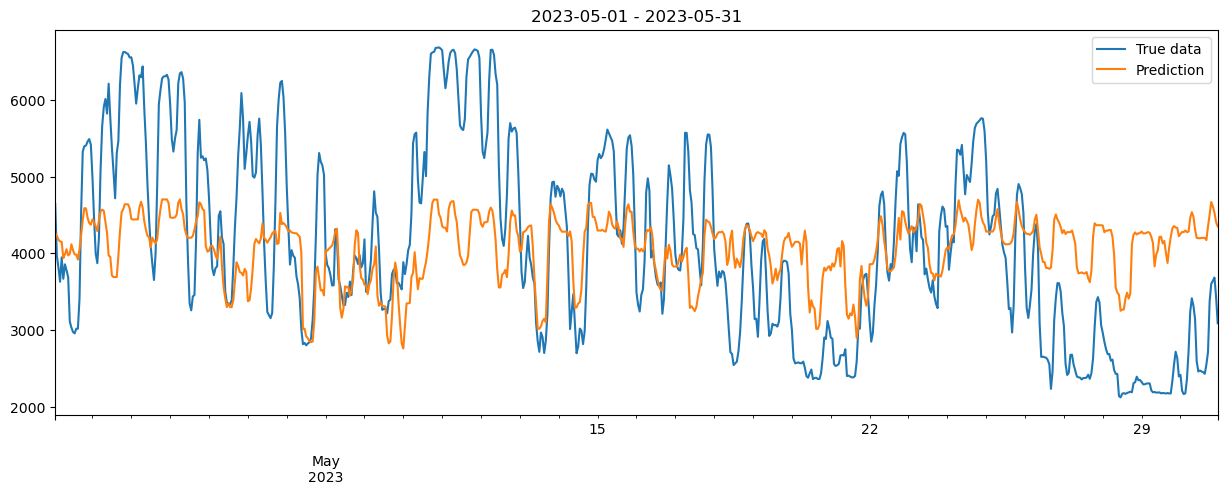

In [80]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(brown_coal_df, brown_coal_test, plot_start, plot_end)

##### Save model

In [81]:
# save
mname = "brown_coal_xgboost_cv_5years_100clusters"
brown_coal_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# brown_coal_xgb = xgb.XGBRegressor()
# brown_coal_xgb.load_model(f"{mpath}/models/{mname}.json")


## Hard Coal

##### Load data

In [82]:
hard_coal_df = pd.read_parquet(f"{fpath}/hard_coal_data_final_20180601-20230531.parquet")

##### Add datetime features

In [83]:
hard_coal_df = add_datetime_features(hard_coal_df)

##### Create train/test split

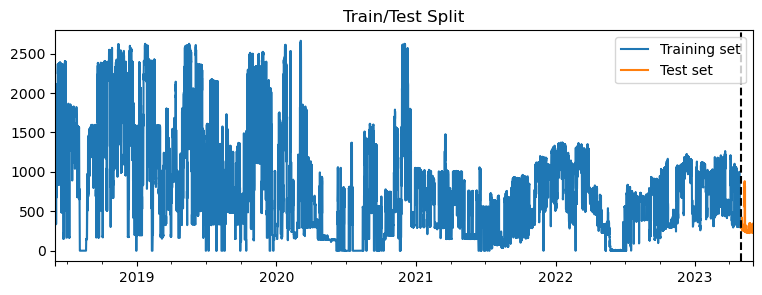

In [84]:
split_date = "2023-05-01"
# split_date = "2022-06-01"
hard_coal_train, hard_coal_test = train_test_split(hard_coal_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:1048.02485	validation_1-rmse:301.60048
[301]	validation_0-rmse:405.53072	validation_1-rmse:99.82955
RSME = 96.11
MAPE = 0.19


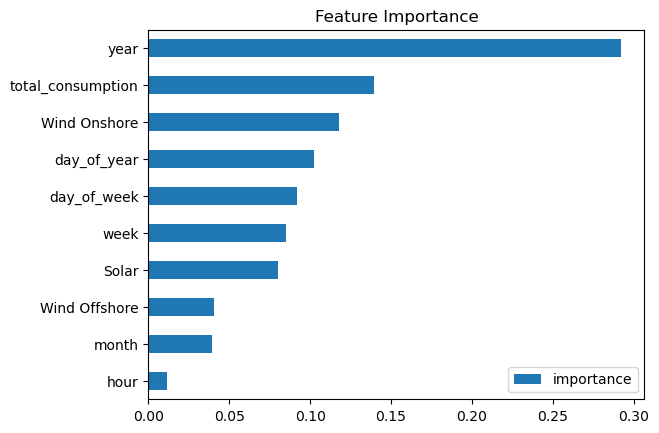

In [86]:
base_xgb, hard_coal_fi = run_baseline_xgboost(hard_coal_train, hard_coal_test, learning_rate=0.005)

In [41]:
hard_coal_fi.sort_values(by="importance", ascending=False).index

Index(['year', 'total_consumption', 'month', 'Wind Onshore', 'Solar',
       'day_of_week', 'Wind Offshore', 'hour'],
      dtype='object')

In [43]:
# keep some reasonable features despite apparently negligible feature importance 
hard_coal_features = ['year', 'total_consumption', 'month', 'Wind Onshore', 'Solar',
       'day_of_week', 'Wind Offshore', 'hour']

##### Step 2: Grid search with cross-validation

In [44]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.001, 0.005],
    "max_depth": [4,6],
}
hard_coal_xgb =  run_cv_xgboost(hard_coal_train, hard_coal_features, params)

Running cross validation...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.001, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:1126.79142	validation_1-rmse:240.61428
[500]	validation_0-rmse:797.38878	validation_1-rmse:143.38271
[669]	validation_0-rmse:725.08008	validation_1-rmse:140.39634
[CV 1/3; 1/4] END learning_rate=0.001, max_depth=4, n_estimators=2000;, score=-557.507 total time=  10.8s
[CV 2/3; 1/4] START learning_rate=0.001, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:1126.78913	validation_1-rmse:240.61428
[500]	validation_0-rmse:796.78900	validation_1-rmse:142.38335
[686]	validation_0-rmse:718.03002	validation_1-rmse:139.10135
[CV 2/3; 1/4] END learning_rate=0.001, max_depth=4, n_estimators=2000;, score=-723.097 total time=  13.1s
[CV 3/3; 1/4] START learning_rate=0.001, max_depth=4, n_estimators=2000.........
[0]	validation_0-rmse:1126.78775	validation_1-rmse:240.47248
[463]	validation_0-rmse:81

##### Predict held-out test data

In [45]:
hard_coal_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [87]:
hard_coal_xgb = base_xgb

In [88]:
hard_coal_test, rmse, mape = predict_test(hard_coal_test, hard_coal_xgb)

RSME = 96.11
MAPE = 0.19


##### Plot predictions and actual generation

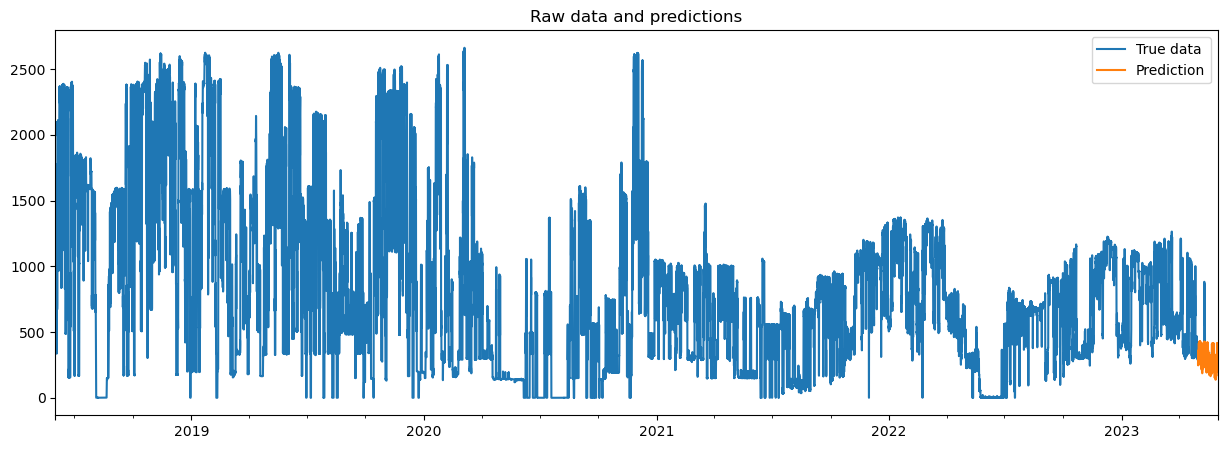

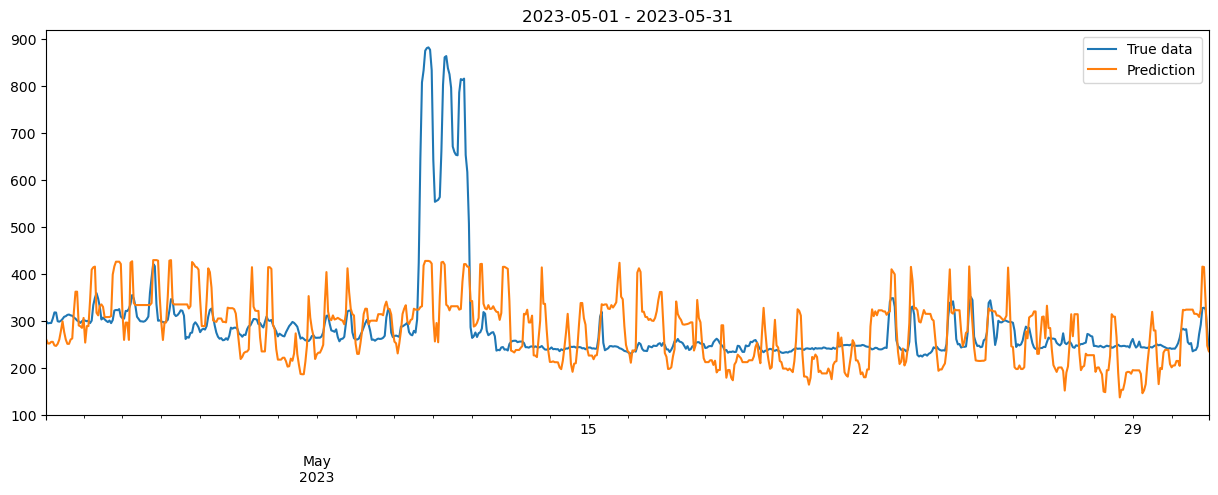

In [89]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(hard_coal_df, hard_coal_test, plot_start, plot_end)

##### Save model

In [90]:
# save
mname = "hard_coal_xgboost_cv_5years_100clusters"
hard_coal_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# hard_coal_xgb = xgb.XGBRegressor()
# hard_coal_xgb.load_model(f"{mpath}/models/{mname}.json")


## Gas

##### Load data

In [91]:
gas_df = pd.read_parquet(f"{fpath}/gas_data_final_20180601-20230531.parquet")

##### Add datetime features

In [92]:
gas_df = add_datetime_features(gas_df)

##### Create train/test split

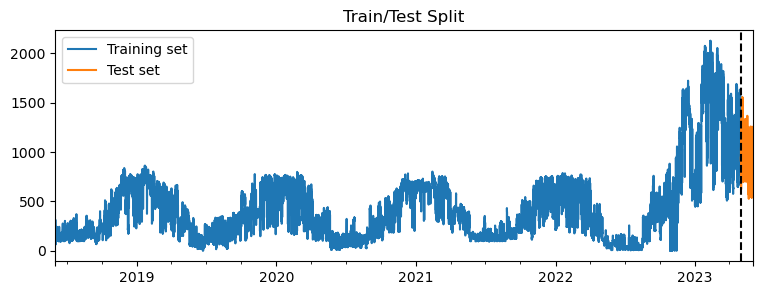

In [93]:
split_date = "2023-05-01"
# split_date = "2022-06-01"
gas_train, gas_test = train_test_split(gas_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:547.39845	validation_1-rmse:940.66385
[447]	validation_0-rmse:111.81411	validation_1-rmse:155.36583
RSME = 152.12
MAPE = 0.13


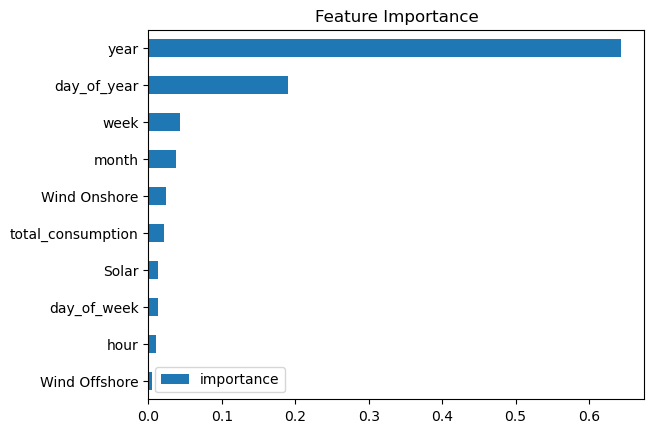

In [94]:
base_xgb, gas_fi = run_baseline_xgboost(gas_train, gas_test, learning_rate=0.005)

In [56]:
gas_fi.sort_values(by="importance", ascending=False).index

Index(['year', 'month', 'Wind Onshore', 'total_consumption', 'Solar',
       'day_of_week', 'hour', 'Wind Offshore'],
      dtype='object')

In [57]:
# keep some reasonable features despite apparently negligible feature importance 
gas_features = ['year', 'month', 'Wind Onshore', 'total_consumption', 'Solar',
       'day_of_week', 'hour', 'Wind Offshore']

##### Step 2: Grid search with cross-validation

In [58]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005],
    "max_depth": [6],
}
gas_xgb =  run_cv_xgboost(gas_train, gas_features, params)

Running cross validation...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:532.18413	validation_1-rmse:1143.54874
[500]	validation_0-rmse:234.70668	validation_1-rmse:848.62121
[1000]	validation_0-rmse:223.75082	validation_1-rmse:809.90660
[1500]	validation_0-rmse:222.85021	validation_1-rmse:799.13192
[1999]	validation_0-rmse:222.90976	validation_1-rmse:792.27288
[CV 1/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-786.392 total time= 1.3min
[CV 2/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:531.74165	validation_1-rmse:1143.54390
[500]	validation_0-rmse:139.78907	validation_1-rmse:746.97324
[1000]	validation_0-rmse:121.30817	validation_1-rmse:651.98039
[1500]	validation_0-rmse:118.02219	validation_1-rmse:625.13355
[1999]	validation_0-rmse:116.28316	validation_1-rmse:608.08411
[CV 2/3; 1/1] END lea

##### Predict held-out test data

In [59]:
gas_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [95]:
gas_xgb = base_xgb

In [96]:
gas_test, rmse, mape = predict_test(gas_test, gas_xgb)

RSME = 152.12
MAPE = 0.13


##### Plot predictions and actual generation

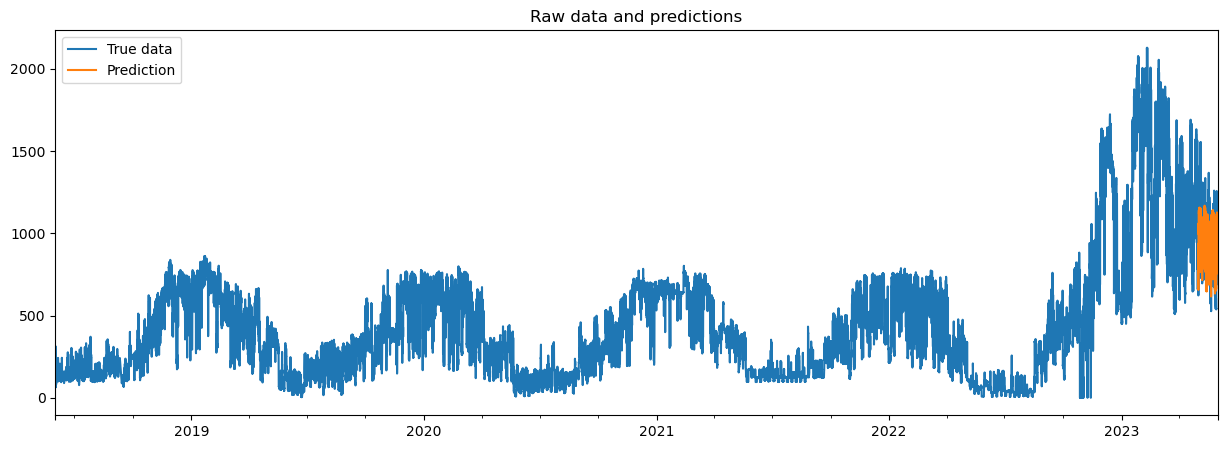

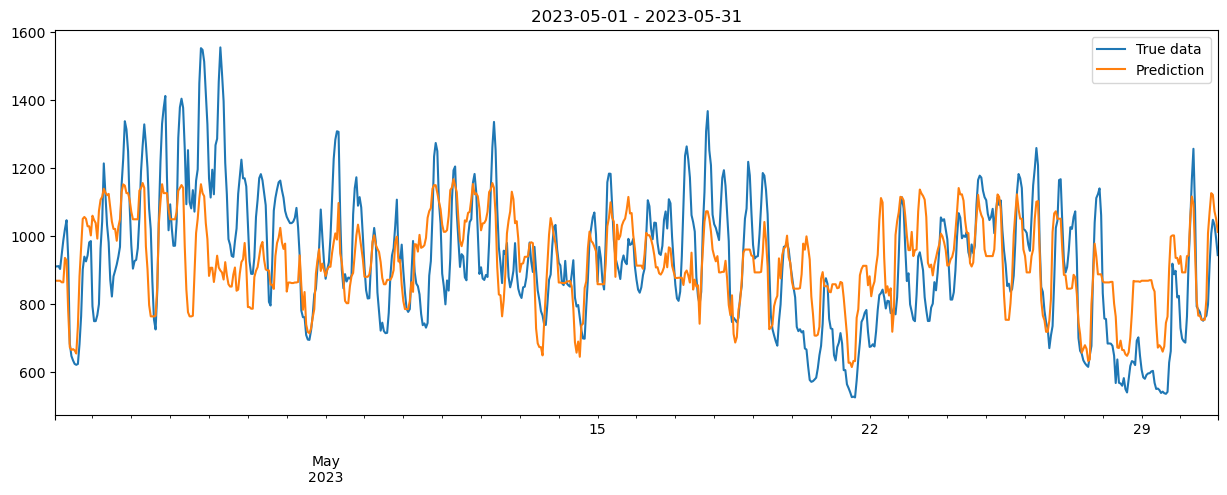

In [97]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(gas_df, gas_test, plot_start, plot_end)

##### Save model

In [98]:
# save
mname = "gas_xgboost_cv_5years_100clusters"
gas_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# gas_xgb = xgb.XGBRegressor()
# gas_xgb.load_model(f"{mpath}/models/{mname}.json")


## Other Fossils

##### Load data

In [5]:
other_fossils_df = pd.read_parquet(f"{fpath}/other_fossils_data_final_20180601-20230531.parquet")

##### Add datetime features

In [6]:
other_fossils_df = add_datetime_features(other_fossils_df)

##### Create train/test split

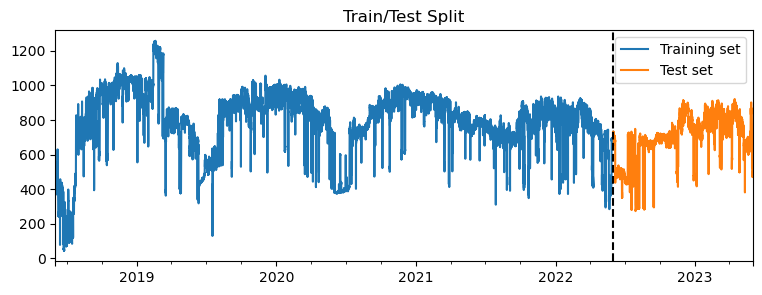

In [19]:
# split_date = "2023-05-01"
split_date = "2022-06-01"
other_fossils_train, other_fossils_test = train_test_split(other_fossils_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:810.57961	validation_1-rmse:701.37623
[500]	validation_0-rmse:92.87602	validation_1-rmse:128.84245
[557]	validation_0-rmse:80.97197	validation_1-rmse:129.97445
RSME = 128.83
MAPE = 0.17


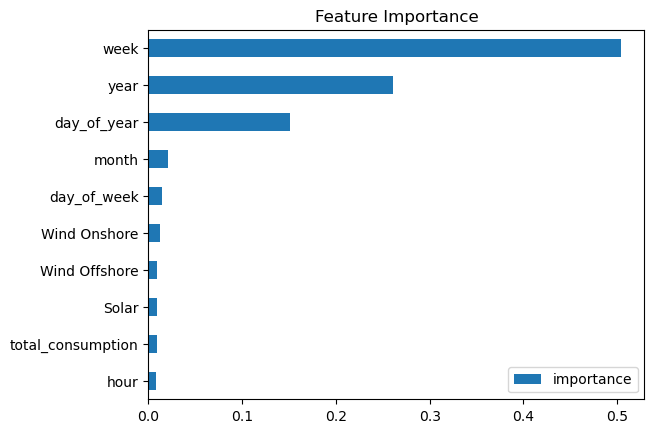

In [20]:
base_xgb, other_fossils_fi = run_baseline_xgboost(other_fossils_train, other_fossils_test, learning_rate=0.005)

In [9]:
other_fossils_fi.sort_values(by="importance", ascending=False).index

Index(['year', 'week', 'day_of_year', 'month', 'day_of_week', 'Wind Onshore',
       'total_consumption', 'Solar', 'Wind Offshore', 'hour'],
      dtype='object')

In [13]:
# keep some reasonable features despite apparently negligible feature importance 
other_fossils_features = list(other_fossils_df.columns)
# other_fossils_features = []

##### Step 2: Grid search with cross-validation

In [58]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005],
    "max_depth": [6],
}
other_fossils_xgb =  run_cv_xgboost(other_fossils_train, other_fossils_features, params)

Running cross validation...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:532.18413	validation_1-rmse:1143.54874
[500]	validation_0-rmse:234.70668	validation_1-rmse:848.62121
[1000]	validation_0-rmse:223.75082	validation_1-rmse:809.90660
[1500]	validation_0-rmse:222.85021	validation_1-rmse:799.13192
[1999]	validation_0-rmse:222.90976	validation_1-rmse:792.27288
[CV 1/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-786.392 total time= 1.3min
[CV 2/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:531.74165	validation_1-rmse:1143.54390
[500]	validation_0-rmse:139.78907	validation_1-rmse:746.97324
[1000]	validation_0-rmse:121.30817	validation_1-rmse:651.98039
[1500]	validation_0-rmse:118.02219	validation_1-rmse:625.13355
[1999]	validation_0-rmse:116.28316	validation_1-rmse:608.08411
[CV 2/3; 1/1] END lea

##### Predict held-out test data

In [21]:
other_fossils_xgb = base_xgb

In [15]:
other_fossils_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [22]:
other_fossils_test, rmse, mape = predict_test(other_fossils_test, other_fossils_xgb)

RSME = 128.83
MAPE = 0.17


##### Plot predictions and actual generation

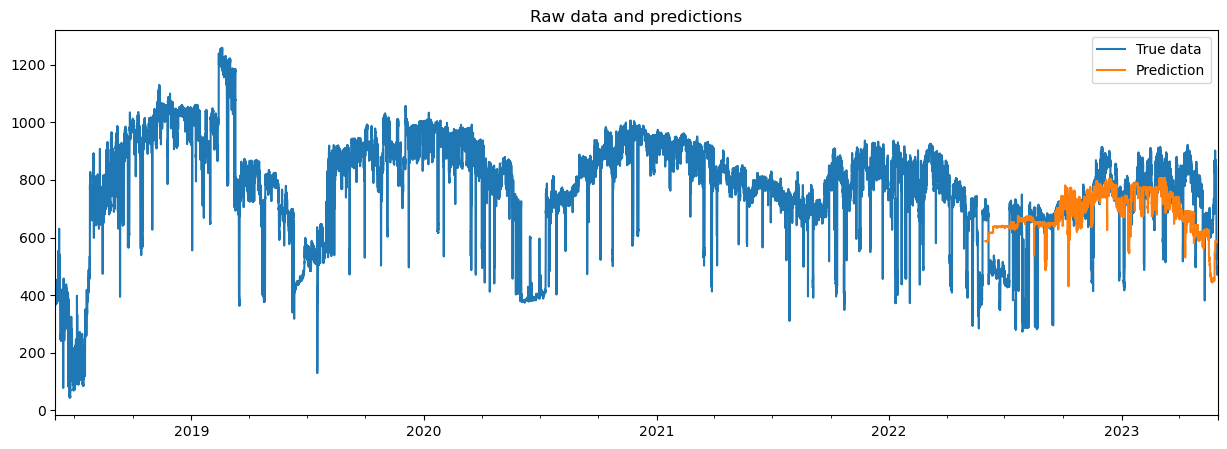

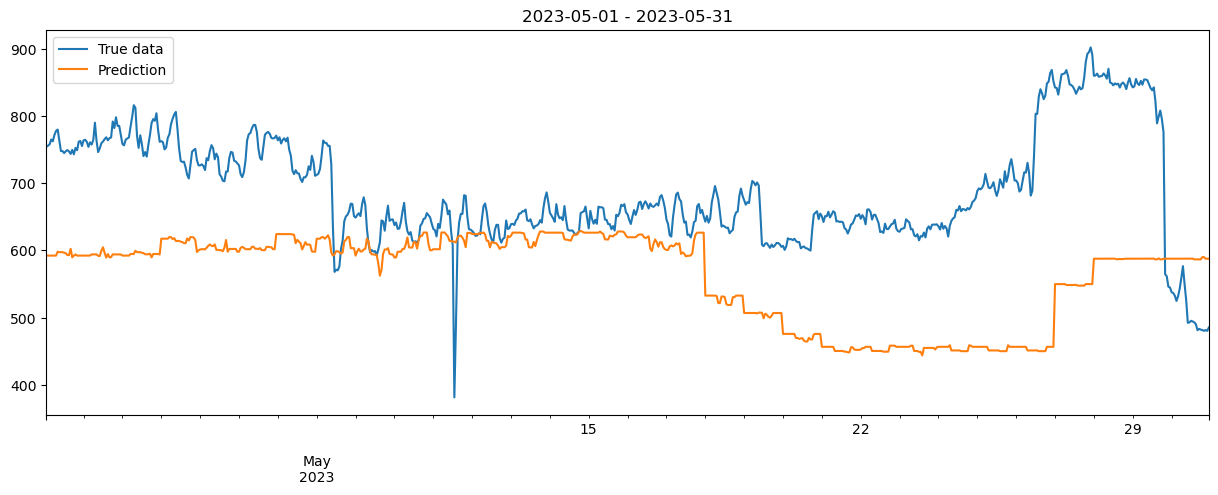

In [23]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(other_fossils_df, other_fossils_test, plot_start, plot_end)

##### Save model

In [24]:
# save
mname = "other_fossils_xgboost_cv_5years_100clusters"
other_fossils_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# other_fossils_xgb = xgb.XGBRegressor()
# other_fossils_xgb.load_model(f"{mpath}/models/{mname}.json")


## Other Renewables

##### Load data

In [25]:
other_renewables_df = pd.read_parquet(f"{fpath}/other_renewables_data_final_20180601-20230531.parquet")

##### Add datetime features

In [26]:
other_renewables_df = add_datetime_features(other_renewables_df)

##### Create train/test split

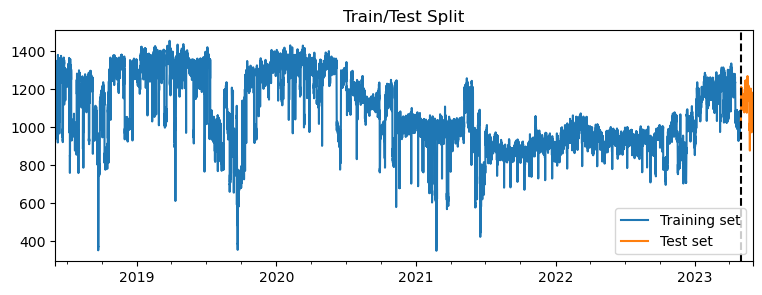

In [34]:
split_date = "2023-05-01"
# split_date = "2022-06-01"
other_renewables_train, other_renewables_test = train_test_split(other_renewables_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:1090.91917	validation_1-rmse:1138.58342
[500]	validation_0-rmse:112.44404	validation_1-rmse:203.63336
[1000]	validation_0-rmse:59.00800	validation_1-rmse:131.29121
[1500]	validation_0-rmse:53.58578	validation_1-rmse:126.89153
[1563]	validation_0-rmse:53.11886	validation_1-rmse:127.05649
RSME = 126.83
MAPE = 0.10


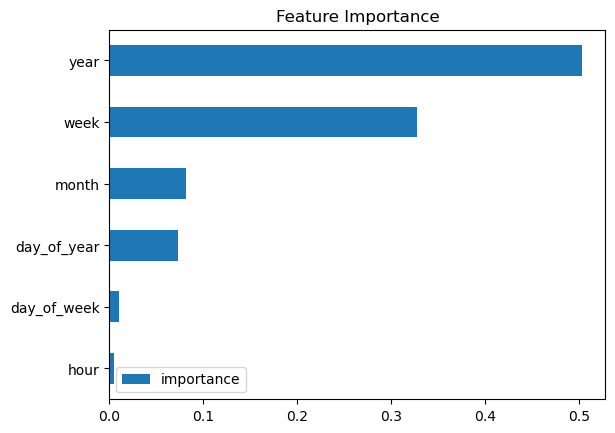

In [35]:
base_xgb, other_renewables_fi = run_baseline_xgboost(other_renewables_train, other_renewables_test, learning_rate=0.005)

In [36]:
other_renewables_fi.sort_values(by="importance", ascending=False).index

Index(['year', 'week', 'month', 'day_of_year', 'day_of_week', 'hour'], dtype='object')

In [37]:
# keep some reasonable features despite apparently negligible feature importance 
other_renewables_features = list(other_renewables_df.columns)
# other_renewables_features = []

##### Step 2: Grid search with cross-validation

In [58]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005],
    "max_depth": [6],
}
other_renewables_xgb =  run_cv_xgboost(other_renewables_train, other_renewables_features, params)

Running cross validation...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:532.18413	validation_1-rmse:1143.54874
[500]	validation_0-rmse:234.70668	validation_1-rmse:848.62121
[1000]	validation_0-rmse:223.75082	validation_1-rmse:809.90660
[1500]	validation_0-rmse:222.85021	validation_1-rmse:799.13192
[1999]	validation_0-rmse:222.90976	validation_1-rmse:792.27288
[CV 1/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-786.392 total time= 1.3min
[CV 2/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:531.74165	validation_1-rmse:1143.54390
[500]	validation_0-rmse:139.78907	validation_1-rmse:746.97324
[1000]	validation_0-rmse:121.30817	validation_1-rmse:651.98039
[1500]	validation_0-rmse:118.02219	validation_1-rmse:625.13355
[1999]	validation_0-rmse:116.28316	validation_1-rmse:608.08411
[CV 2/3; 1/1] END lea

##### Predict held-out test data

In [38]:
other_renewables_xgb = base_xgb

In [15]:
other_renewables_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [39]:
other_renewables_test, rmse, mape = predict_test(other_renewables_test, other_renewables_xgb)

RSME = 126.83
MAPE = 0.10


##### Plot predictions and actual generation

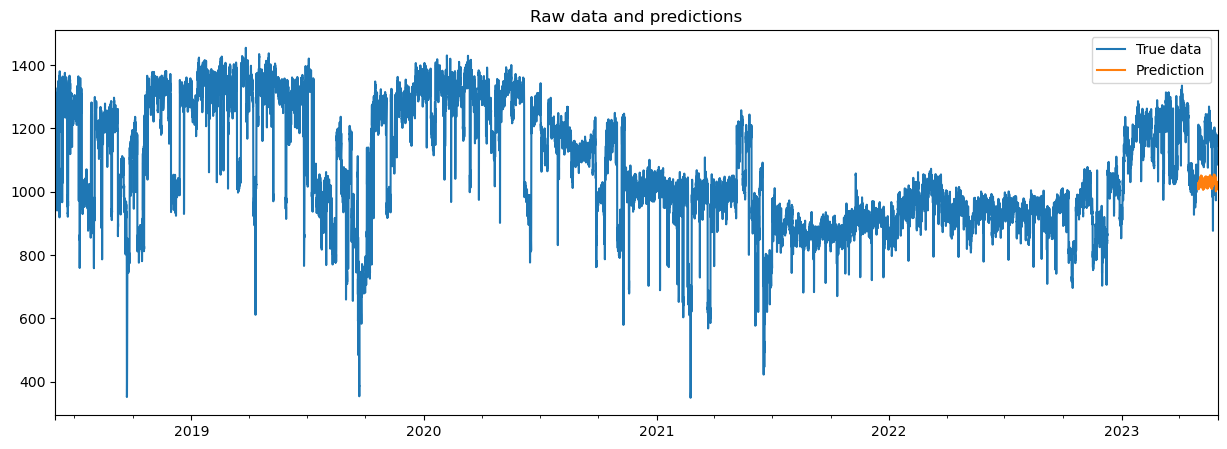

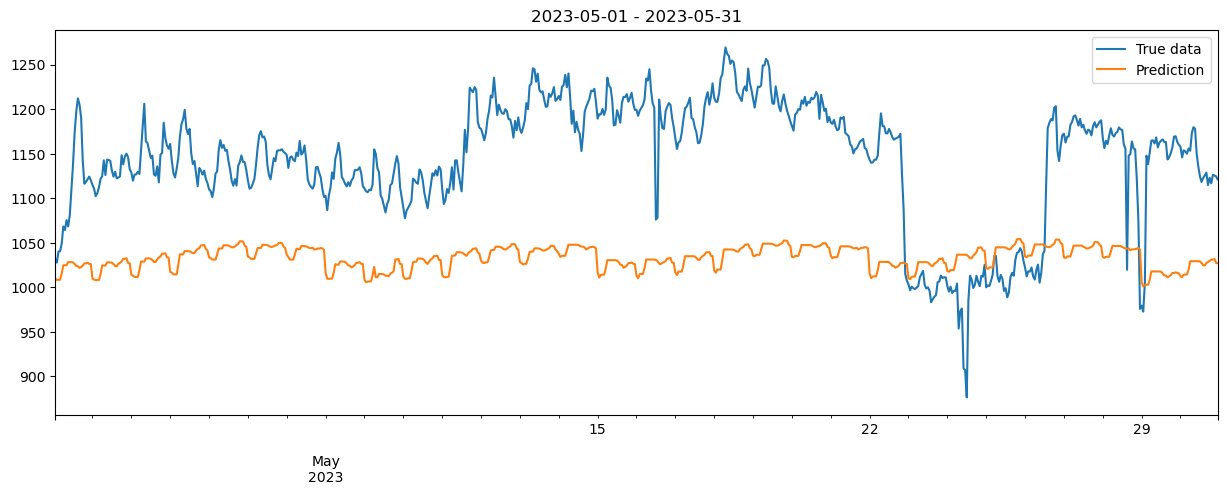

In [40]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(other_renewables_df, other_renewables_test, plot_start, plot_end)

##### Save model

In [41]:
# save
mname = "other_renewables_xgboost_cv_5years_100clusters"
other_renewables_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# other_renewables_xgb = xgb.XGBRegressor()
# other_renewables_xgb.load_model(f"{mpath}/models/{mname}.json")


## Hydro Pumped Storage

##### Load data

In [42]:
hydro_pumped_storage_df = pd.read_parquet(f"{fpath}/hydro_pumped_storage_data_final_20180601-20230531.parquet")

##### Add datetime features

In [43]:
hydro_pumped_storage_df = add_datetime_features(hydro_pumped_storage_df)

##### Create train/test split

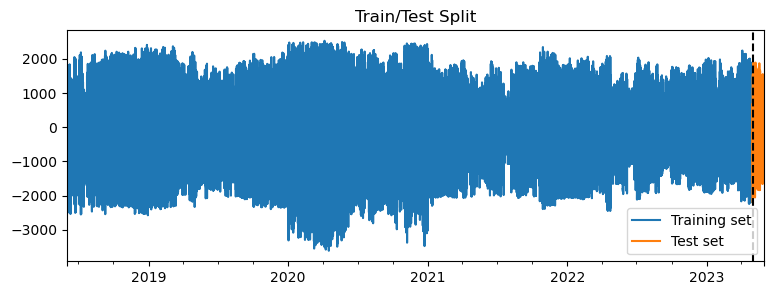

In [50]:
split_date = "2023-05-01"
# split_date = "2022-06-01"
hydro_pumped_storage_train, hydro_pumped_storage_test = train_test_split(hydro_pumped_storage_df, split_date)

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:1116.32951	validation_1-rmse:1006.64424
[500]	validation_0-rmse:627.62931	validation_1-rmse:598.91546
[1000]	validation_0-rmse:571.05127	validation_1-rmse:542.09079
[1500]	validation_0-rmse:545.97263	validation_1-rmse:524.65999
[1999]	validation_0-rmse:532.37002	validation_1-rmse:516.68078
RSME = 516.65
MAPE = 2992806549573945.00


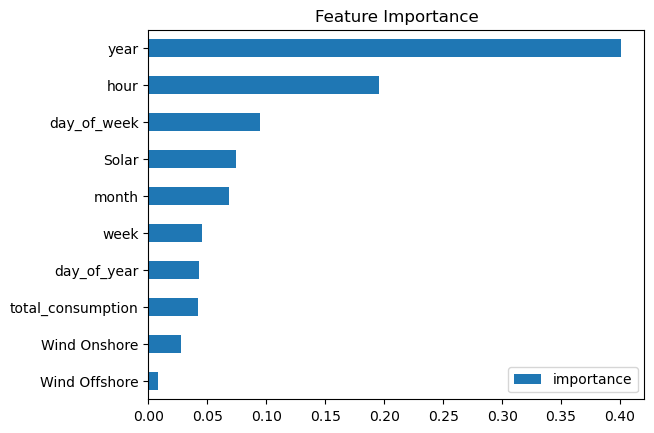

In [51]:
base_xgb, hydro_pumped_storage_fi = run_baseline_xgboost(hydro_pumped_storage_train, hydro_pumped_storage_test, learning_rate=0.005)

In [46]:
hydro_pumped_storage_fi.sort_values(by="importance", ascending=False).index

Index(['year', 'hour', 'Solar', 'day_of_week', 'total_consumption',
       'day_of_year', 'month', 'week', 'Wind Onshore', 'Wind Offshore'],
      dtype='object')

In [13]:
# keep some reasonable features despite apparently negligible feature importance 
hydro_pumped_storage_features = list(hydro_pumped_storage_df.columns)
# hydro_pumped_storage_features = []

##### Step 2: Grid search with cross-validation

In [58]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005],
    "max_depth": [6],
}
hydro_pumped_storage_xgb =  run_cv_xgboost(hydro_pumped_storage_train, hydro_pumped_storage_features, params)

Running cross validation...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:532.18413	validation_1-rmse:1143.54874
[500]	validation_0-rmse:234.70668	validation_1-rmse:848.62121
[1000]	validation_0-rmse:223.75082	validation_1-rmse:809.90660
[1500]	validation_0-rmse:222.85021	validation_1-rmse:799.13192
[1999]	validation_0-rmse:222.90976	validation_1-rmse:792.27288
[CV 1/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-786.392 total time= 1.3min
[CV 2/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:531.74165	validation_1-rmse:1143.54390
[500]	validation_0-rmse:139.78907	validation_1-rmse:746.97324
[1000]	validation_0-rmse:121.30817	validation_1-rmse:651.98039
[1500]	validation_0-rmse:118.02219	validation_1-rmse:625.13355
[1999]	validation_0-rmse:116.28316	validation_1-rmse:608.08411
[CV 2/3; 1/1] END lea

##### Predict held-out test data

In [52]:
hydro_pumped_storage_xgb = base_xgb

In [15]:
hydro_pumped_storage_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [53]:
hydro_pumped_storage_test, rmse, mape = predict_test(hydro_pumped_storage_test, hydro_pumped_storage_xgb)

RSME = 516.65
MAPE = 2992806549573945.00


##### Plot predictions and actual generation

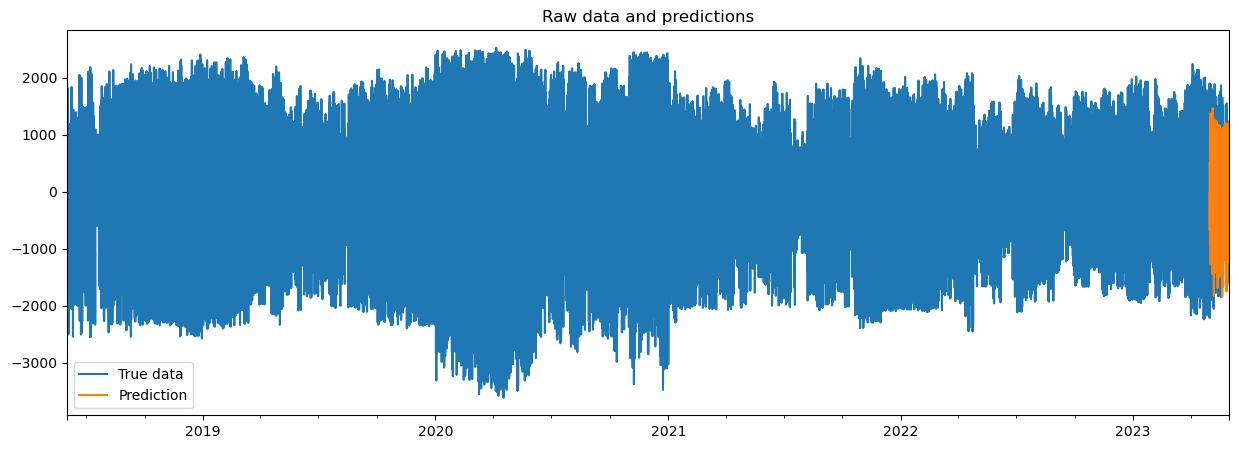

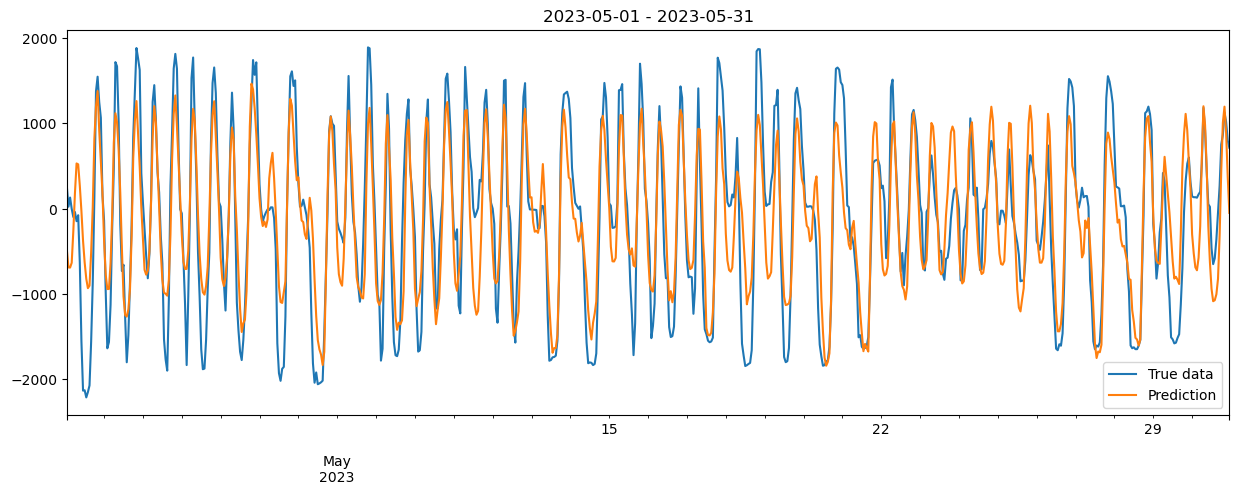

In [54]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(hydro_pumped_storage_df, hydro_pumped_storage_test, plot_start, plot_end)

##### Save model

In [55]:
# save
mname = "hydro_pumped_storage_xgboost_cv_5years_100clusters"
hydro_pumped_storage_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# hydro_pumped_storage_xgb = xgb.XGBRegressor()
# hydro_pumped_storage_xgb.load_model(f"{mpath}/models/{mname}.json")


## Price

##### Load data

In [57]:
price_df = pd.read_parquet(f"{fpath}/price_data_final_20181001-20230531.parquet")

##### Add datetime features

In [58]:
price_df = add_datetime_features(price_df)

##### Create train/test split

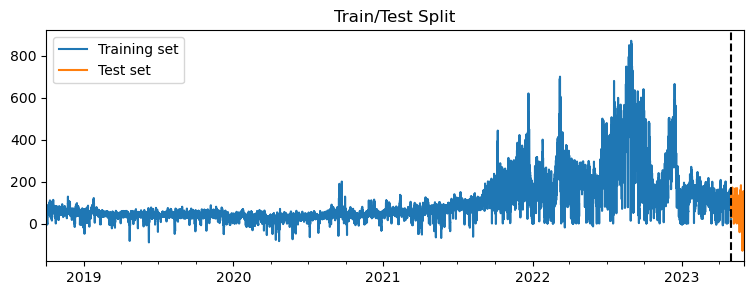

In [61]:
split_date = "2023-05-01"
# split_date = "2022-06-01"
price_train, price_test = train_test_split(price_df, split_date, target="prices")

##### Step 1: Run basic model on all features to determine feature importance

[0]	validation_0-rmse:146.04842	validation_1-rmse:89.99145
[500]	validation_0-rmse:25.91882	validation_1-rmse:22.21972
[510]	validation_0-rmse:25.48550	validation_1-rmse:22.29356
RSME = 22.03
MAPE = 1244926866614787.50


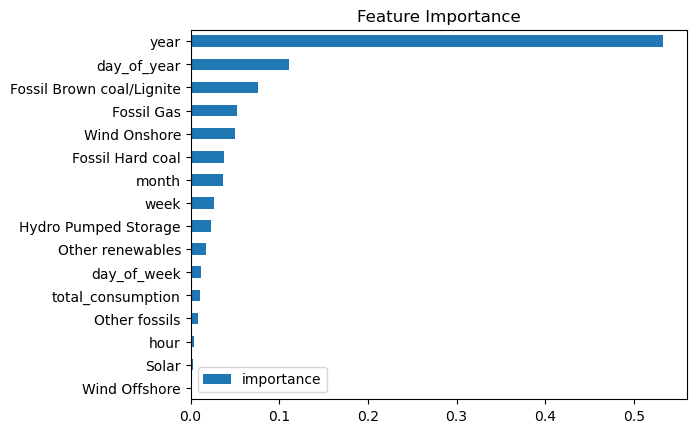

In [65]:
base_xgb, price_fi = run_baseline_xgboost(price_train, price_test, learning_rate=0.005, target="prices")

In [66]:
price_fi.sort_values(by="importance", ascending=False).index

Index(['year', 'day_of_year', 'Fossil Brown coal/Lignite', 'Fossil Gas',
       'Wind Onshore', 'Fossil Hard coal', 'month', 'week',
       'Hydro Pumped Storage', 'Other renewables', 'day_of_week',
       'total_consumption', 'Other fossils', 'hour', 'Solar', 'Wind Offshore'],
      dtype='object')

In [13]:
# keep some reasonable features despite apparently negligible feature importance 
price_features = list(price_df.columns)
price_features = []

##### Step 2: Grid search with cross-validation

In [58]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.005],
    "max_depth": [6],
}
price_xgb =  run_cv_xgboost(price_train, price_features, params)

Running cross validation...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:532.18413	validation_1-rmse:1143.54874
[500]	validation_0-rmse:234.70668	validation_1-rmse:848.62121
[1000]	validation_0-rmse:223.75082	validation_1-rmse:809.90660
[1500]	validation_0-rmse:222.85021	validation_1-rmse:799.13192
[1999]	validation_0-rmse:222.90976	validation_1-rmse:792.27288
[CV 1/3; 1/1] END learning_rate=0.005, max_depth=6, n_estimators=2000;, score=-786.392 total time= 1.3min
[CV 2/3; 1/1] START learning_rate=0.005, max_depth=6, n_estimators=2000.........
[0]	validation_0-rmse:531.74165	validation_1-rmse:1143.54390
[500]	validation_0-rmse:139.78907	validation_1-rmse:746.97324
[1000]	validation_0-rmse:121.30817	validation_1-rmse:651.98039
[1500]	validation_0-rmse:118.02219	validation_1-rmse:625.13355
[1999]	validation_0-rmse:116.28316	validation_1-rmse:608.08411
[CV 2/3; 1/1] END lea

##### Predict held-out test data

In [67]:
price_xgb = base_xgb

In [15]:
price_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [69]:
price_test, rmse, mape = predict_test(price_test, price_xgb, target="prices")

RSME = 22.03
MAPE = 1244926866614787.50


##### Plot predictions and actual generation

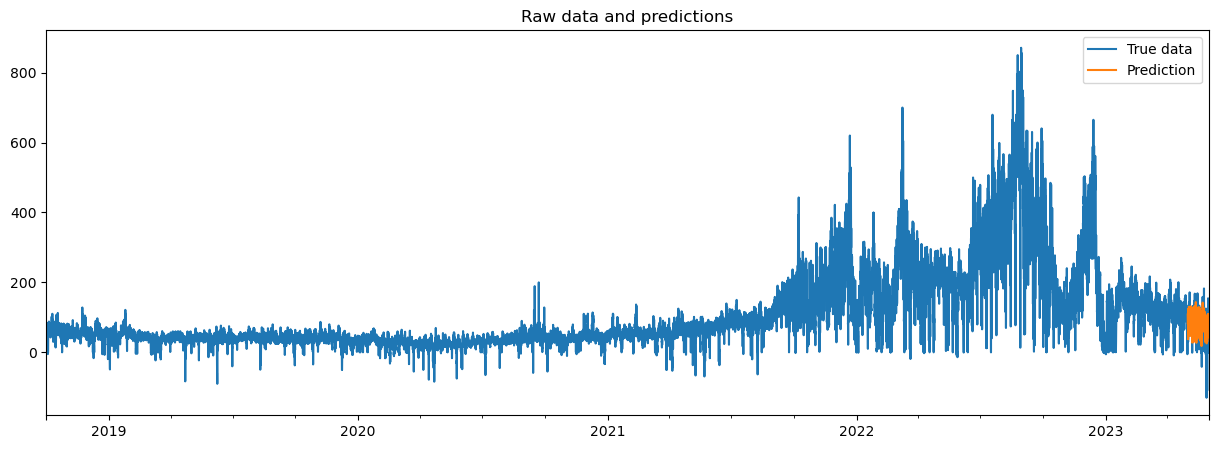

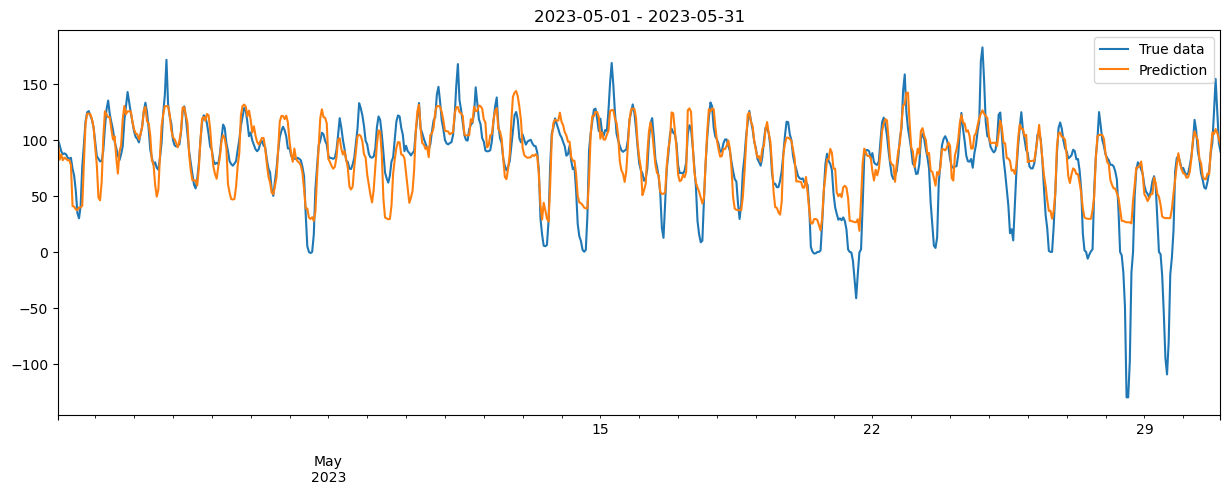

In [71]:
plot_start = "2023-05-01"
plot_end = "2023-05-31"
plot_predictions(price_df, price_test, plot_start, plot_end, target="prices")

##### Save model

In [72]:
# save
mname = "price_xgboost_cv_5years_100clusters"
price_xgb.save_model(f"{fpath}/models/{mname}.json")

# read
# price_xgb = xgb.XGBRegressor()
# price_xgb.load_model(f"{mpath}/models/{mname}.json")
